In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
from sklearn import datasets
import matplotlib.pyplot as plt
from torch.optim import Adam

from torch.utils.data import DataLoader
from tqdm import notebook

In [18]:
y = -6 * torch.rand(100000) + 3
z = np.random.gamma(1,0.3, size = 100000)
x = np.tanh(y) + z
tanh_data = torch.vstack([x, y]).T

In [19]:
class ScoreNet(nn.Module):
    
    def __init__(self, marginal_prob_std):
        super().__init__()
        self.act = nn.GELU()#lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std
        self.hidden_units = 32
        # inputs of data (x,y), timestep t
        self.mlp = nn.Sequential(
            nn.Linear(3, int(self.hidden_units), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units), int(self.hidden_units/2), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units/2), int(self.hidden_units/4), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units/4), int(self.hidden_units/8), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units/8), int(self.hidden_units/16), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units/16), int(self.hidden_units/8), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units/8), int(self.hidden_units/4), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units/4), int(self.hidden_units/2), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units/2), int(self.hidden_units), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units), 2, bias=True)
        )
        
        
        
    def forward(self, x):
        t = x[:, 2]
        x = self.mlp(x)
        x = x / self.marginal_prob_std(t)[:, None]
        return x

In [20]:
#@title Set up the SDE

device = 'cpu' #@param ['cuda', 'cpu'] {'type':'string'}

def marginal_prob_std(t, sigma):
    """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

    Args:    
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.  

    Returns:
    The standard deviation.
    """    
    t = torch.tensor(t, device=device)
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
    """Compute the diffusion coefficient of our SDE.

    Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

    Returns:
    The vector of diffusion coefficients.
    """
    return torch.tensor(sigma**t, device=device)
  
sigma =  25.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [69]:
marginal_prob_std_fn(torch.rand(100, device='cpu'))[:,None]

<ipython-input-20-4fb5fc172600>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


tensor([[0.7761],
        [3.3794],
        [2.3632],
        [0.4815],
        [0.8267],
        [1.9817],
        [5.4135],
        [4.5404],
        [3.4016],
        [6.0824],
        [3.0183],
        [9.7669],
        [0.2665],
        [0.0961],
        [1.0723],
        [5.5362],
        [4.2275],
        [9.4377],
        [1.4346],
        [1.9198],
        [0.5176],
        [0.7947],
        [5.3434],
        [5.0625],
        [2.9661],
        [1.7120],
        [4.8789],
        [1.3229],
        [2.4796],
        [2.8725],
        [9.7385],
        [3.1977],
        [2.9197],
        [4.3951],
        [7.2207],
        [8.4983],
        [1.1532],
        [3.1068],
        [0.9151],
        [2.0311],
        [8.6437],
        [0.8982],
        [0.4804],
        [5.0538],
        [0.7270],
        [2.6631],
        [2.8809],
        [7.5319],
        [3.2815],
        [4.2449],
        [8.3987],
        [4.2017],
        [0.6914],
        [3.1433],
        [0.4051],
        [0

In [21]:
#@title Define the loss function (double click to expand or collapse)

def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    """The loss function for training score-based generative models.

    Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the standard deviation of 
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
    """
    random_t = torch.rand(x.shape[0], device='cpu') * (1. - eps) + eps  
    std = marginal_prob_std(random_t)
    random_t = torch.reshape(random_t, (x.shape[0], 1))
    z = torch.randn_like(x)
    perturbed_x = x + z * std[:, None]
    x_with_t = torch.hstack([perturbed_x,random_t])
    x_with_t = x_with_t.to(torch.float32)
    score = model(x_with_t)
    loss = torch.mean(torch.sum((score * std[:, None] + z)**2, dim=0))
    return loss

In [9]:
epochs = 100
batch_size = 1000
lr=1e-4


score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn)
score_model = score_model.to(device)
optimizer = Adam(score_model.parameters(), lr=lr)
dataset = tanh_data
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
tqdm_epoch = notebook.trange(epochs)
losses = []
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x in data_loader:
        #print(x)
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()    
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'ckpt_2.pth')
    losses.append(avg_loss / num_items)

  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-6-4fb5fc172600>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


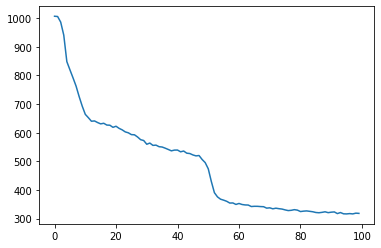

In [11]:
plt.plot(losses)

In [22]:
score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn)
score_model = score_model.to(device)

In [23]:
#@title Define the Predictor-Corrector sampler (double click to expand or collapse)

signal_to_noise_ratio = 0.16 #@param {'type':'number'}

## The number of sampling steps.
num_steps =  500#@param {'type':'integer'}
def pc_sampler(score_model, 
               marginal_prob_std,
               diffusion_coeff,
               batch_size=2048, 
               num_steps=num_steps, 
               snr=signal_to_noise_ratio,                
               device='cpu',
               eps=1e-3):
    """Generate samples from score-based models with Predictor-Corrector method.

    Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient 
      of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.    
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

    Returns: 
    Samples.
    """
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, 2, device=device) * marginal_prob_std(t)[:, None]
    time_steps = np.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    with torch.no_grad():
        for time_step in notebook.tqdm(time_steps):      
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            batch_time_step_ = torch.reshape(batch_time_step, (x.shape[0], 1))
            x_with_t = torch.hstack([x, batch_time_step_])
            # Corrector step (Langevin MCMC)
            grad = score_model(x_with_t)
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
            x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)      

            # Predictor step (Euler-Maruyama)
            g = diffusion_coeff(batch_time_step)
            x_mean = x + (g**2)[:, None] * score_model(x_with_t) * step_size
            x = x_mean + torch.sqrt(g**2 * step_size)[:, None] * torch.randn_like(x)      

    # The last step does not include any noise
    return x_mean

In [24]:
#@title Sampling (double click to expand or collapse)

## Load the pre-trained checkpoint from disk.
device = 'cpu' #@param ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load('ckpt_2.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 50000 #@param {'type':'integer'}

#@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}
## Generate samples using the specified sampler.
pc_samples= pc_sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)

<ipython-input-20-4fb5fc172600>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/500 [00:00<?, ?it/s]

<ipython-input-20-4fb5fc172600>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


(-3.2, 3.2)

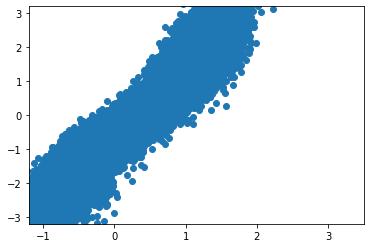

In [27]:
plt.scatter(pc_samples[:,0], pc_samples[:,1])
plt.xlim(-1.2, 3.5)
plt.ylim(-3.2,3.2)

(-3.2, 3.2)

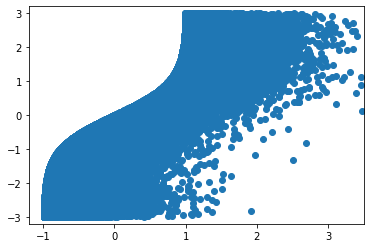

In [28]:
plt.scatter(tanh_data[:,0], tanh_data[:,1])
plt.xlim(-1.2, 3.5)
plt.ylim(-3.2,3.2)

# CDE: tailored method

In [38]:
y = -6 * torch.rand(100000) + 3
z = np.random.gamma(1,0.3, size = 100000)
x = torch.tanh(y) + z

In [42]:
x.shape[0]

100000

In [53]:
def simulate_y(x):
    z = np.random.gamma(1,0.3, size = x.shape[0])
    return torch.atanh(x - z)

In [59]:
sim = simulate_y(x) 

In [60]:
[i for i in sim if sim.isnan()]

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [48]:
x

tensor([ 0.2224, -0.6000,  0.8973,  ...,  1.9023, -0.5227,  1.4565],
       dtype=torch.float64)

In [ ]:
class ScoreNet(nn.Module):
    
    def __init__(self, marginal_prob_std):
        super().__init__()
        self.act = nn.GELU()#lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std
        self.hidden_units = 32
        # inputs x_t, condition y, timestep t
        self.mlp = nn.Sequential(
            nn.Linear(3, int(self.hidden_units), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units), int(self.hidden_units/2), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units/2), int(self.hidden_units/4), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units/4), int(self.hidden_units/8), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units/8), int(self.hidden_units/16), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units/16), int(self.hidden_units/8), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units/8), int(self.hidden_units/4), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units/4), int(self.hidden_units/2), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units/2), int(self.hidden_units), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units), 2, bias=True)
        )
        
        
        
    def forward(self, x):
        t = x[:, 2]
        x = self.mlp(x)
        x = x / self.marginal_prob_std(t)[:, None]
        return x

In [ ]:
epochs = 100
batch_size = 1000
lr=1e-4


score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn)
score_model = score_model.to(device)
optimizer = Adam(score_model.parameters(), lr=lr)
dataset = tanh_data
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
tqdm_epoch = notebook.trange(epochs)
losses = []
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x in data_loader:
        #print(x)
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()    
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'ckpt_2.pth')
    losses.append(avg_loss / num_items)

# CDiffE replacement method

I think, in the case of simulating x|y for this synthetic example, the training stays the same. The difference comes in the sampling. For a given y and timestep t, diffuse y to y_t by the standard forward diffusion. Then at each step of the SDE solver, replace the y value with the diffused y_t.

In [108]:
def get_y_t(y_obs, t):
    std = marginal_prob_std_fn(t)
    z = torch.randn_like(y_obs)
    perturbed_y = y_obs + z * std[:, None]
    return perturbed_y

In [109]:
y_obs = torch.tensor(0, dtype = torch.float32)
y_obs = y_obs.repeat(5000)
y_obs = y_obs.reshape(5000,1)

In [110]:
y_obs

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])

In [147]:
t = torch.ones(5000, device=device) * 0.1

In [148]:
t

tensor([0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000])

In [151]:
get_y_t(y_obs, t)

<ipython-input-20-4fb5fc172600>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


tensor([[-0.2454],
        [-0.6866],
        [-0.3605],
        ...,
        [-0.3920],
        [ 0.3200],
        [ 0.1163]])

In [103]:
std = marginal_prob_std_fn(times)

<ipython-input-20-4fb5fc172600>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


In [104]:
z = torch.randn_like(y_obs)
perturbed_y = y_obs + z * std[:, None]

In [183]:
#@title Define the Euler-Maruyama sampler (double click to expand or collapse)

## The number of sampling steps.
num_steps =  1000#@param {'type':'integer'}
def Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std,
                           diffusion_coeff, 
                           y_obs,
                           batch_size=1000, 
                           num_steps=num_steps, 
                           device='cpu', 
                           eps=1e-3):
    """Generate samples from score-based models with the Euler-Maruyama solver.

    Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

    Returns:
    Samples.    
    """
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, 2, device=device) * marginal_prob_std(t)[:, None]
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    y_obs = y_obs.repeat(batch_size)
    y_obs = y_obs.reshape(batch_size,1)
    with torch.no_grad():
        for time_step in notebook.tqdm(time_steps): 

            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            batch_time_step_ = torch.reshape(batch_time_step, (x.shape[0], 1))
            x_with_t = torch.hstack([x, batch_time_step_])
            mean_x = x + (g**2)[:, None] * score_model(x_with_t) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None] * torch.randn_like(x) 
            
            y_obs_t = get_y_t(y_obs, batch_time_step)

            x = torch.hstack([x,y_obs_t])
            x = x[:, [0,2]]
            

    # Do not include any noise in the last sampling step.
    return mean_x

In [184]:
conditional_samples_0 = Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(0, dtype = torch.float32))

conditional_samples_neg = Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(-1.2, dtype = torch.float32))

conditional_samples_pos = Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(1.2, dtype = torch.float32))

<ipython-input-20-4fb5fc172600>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-20-4fb5fc172600>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

(array([  6.,  29., 121., 271., 257., 184.,  94.,  28.,   9.,   1.]),
 array([0.1150606 , 0.31352088, 0.5119812 , 0.71044147, 0.90890175,
        1.107362  , 1.3058224 , 1.5042826 , 1.7027429 , 1.9012032 ,
        2.0996635 ], dtype=float32),
 <a list of 10 Patch objects>)

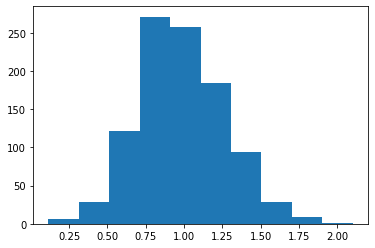

In [192]:
plt.hist(conditional_samples_pos[:,0])

In [193]:
actual_samples_pos = np.random.gamma(1,0.3, size = 1000) + 1.2

(array([498., 282., 117.,  60.,  22.,   9.,   5.,   6.,   0.,   1.]),
 array([1.20010288, 1.42228523, 1.64446758, 1.86664993, 2.08883228,
        2.31101463, 2.53319698, 2.75537933, 2.97756168, 3.19974403,
        3.42192638]),
 <a list of 10 Patch objects>)

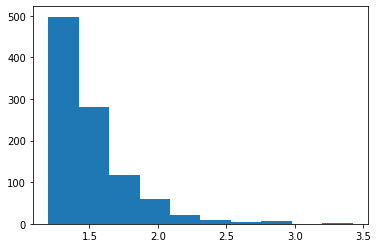

In [194]:
plt.hist(actual_samples_pos)